In [1]:
import csv 
import os
   
import pandas as pd 
import spacy 
# spacy.cli.download("pt_core_news_sm")
# spacy.cli.download("es_core_news_sm")

import requests 
from bs4 import BeautifulSoup
from dataclasses import dataclass

#Sentence Tokenization using sent_tokenize
import nltk
# nltk.download('punkt')
from nltk import word_tokenize,sent_tokenize
from nltk.tokenize import word_tokenize


#Detect language using detect_langs
import langdetect
from langdetect import detect_langs

#Detect language using Lingua
from lingua import Language, LanguageDetectorBuilder

In [2]:

"""
First, I'm gonna get the entire corpus from the "Reddit Post Parsed" folder.
"""
all_post_titles = []
expected_no_comments = 0
corpus = ""
comment_urls = []
all_links = []

with open('log.csv', mode = 'r') as file:
    link_column = []
    title_column = []
    comments_column = []
    all_no_comments = []
    csvFile = csv.reader(file)
    for line in csvFile:
        title_column.append(line[2])
        all_post_titles = title_column[1:]
        comments_column.append(line[9])
        all_no_comments = comments_column[1:]
        link_column.append(line[3])
        all_links = link_column[1:]
    for number in all_no_comments:
        expected_no_comments += int(number)

#loop to open all post titles in create one big corpus of all comments
def create_corpus(titles: list) -> str:
    """
    This function takes in a list of posts titles in the 
    folder "Reddit Post Parsed" and loops through each 
    csv file to filter for proper comments, that are not urls
    and deleted to return the corpus.

    Comments that are just links will be 
    appended to the list "comment_urls"!
    """
    global corpus
    global comment_urls

    count_proper_comments = 0
    no_deleted_comments = 0
    empty = ""
    list_of_comments = []
    
    base_folder = "Update posts files"
    for title in titles:
        title_csv = os.path.join(base_folder, title + "'s post.csv")
        if not os.path.isfile(title_csv):
            print(f"File '{title_csv}' not found.")
            continue
    
        with open(title_csv, mode='r', encoding='utf-8') as file:
            csv_reader = csv.reader(file)
            for row in csv_reader:
                list_of_comments.append(empty.join(row[9:]))

    for comment in list_of_comments:
        if comment.strip() != "Body":
            if comment.strip() == '"deleted"' or comment.strip() == '"removed"':
                no_deleted_comments +=1
                comment = ""
            if comment.strip().startswith('"https:'):
                comment_urls.append(comment.replace('"', "").strip())
            else:
                count_proper_comments += 1 
                corpus = corpus + " " + comment.replace("**", "").replace("#", "").strip()[1:-1] 
    print(f'Number of comments yielded for the corpus (that are not urls or deleted): {count_proper_comments}.') 
    print(f'Number of removed/deleted comments (has been filetered from corpus): {no_deleted_comments}.\n')                  
                
create_corpus(all_post_titles)

Number of comments yielded for the corpus (that are not urls or deleted): 91.
Number of removed/deleted comments (has been filetered from corpus): 5.



In [9]:
@dataclass
class entities:
    name: str
    label: str

#strip out the pronouns, conjunctions, etc.!
# f = open('stop words.txt', 'r')
# stopwords = f.read()
# stopwords = stopwords.split('\n')

with open('stop words.txt', 'r', encoding='utf-8') as f:
    stopwords = f.read()
stopwords = stopwords.split('\n')

# Load the spaCy English & Portuguese models
en_nlp = spacy.load("en_core_web_sm")
pt_nlp = spacy.load('pt_core_news_sm')
pd.set_option("display.max_rows", 200)

#separate into tokenized sentences
tokenizer = nltk.data.load('tokenizers\punkt\english.pickle')
sentences_token = tokenizer.tokenize(corpus)
sentences = []
for sentence in sentences_token:
    if sentence.strip() not in stopwords:
        sentences.append(sentence)

#separate corpus in words
words_token = word_tokenize(corpus)
words = []
#remove any conjunctions, articles, particles, etc.
for word in words_token:
    if word.lower().strip() not in stopwords:
        words.append(word)

def checkW(x: int):
    return (x/len(words))*100

def checkS(x: int):
    return (x/len(sentences))*100

f.close()

print(f'Amount of total sentence tokens: {len(sentences)}.')
print(f'Amount of total word token: {len(words)}.\n')

Amount of total sentence tokens: 171.
Amount of total word token: 1533.



In [ ]:
# METHOD 1: Langdetect each sentence in the corpus

#Sentences with more than one languages detected
mixed_s = []
#Sentences with only one language detected
en_s = []
es_s = []
pt_s = []
discarded = 0
for sentence in sentences:
    #benchmark is with a language probablity over 0.5
    try:
        score = detect_langs(sentence)
        if len(score) > 1:
            mixed_s.append(sentence)
        elif len(score) == 1:
            for s in score:
                if s.lang == 'en' and s.prob >= 0.8:
                    en_s.append(sentence)
                elif s.lang == 'es' and s.prob >= 0.8:
                    es_s.append(sentence)
                elif s.lang == 'pt' and s.prob >= 0.8:
                    pt_s.append(sentence)
                else: 
                    mixed_s.append(sentence)
    except:
        #discard "." or numbers
        # print("This throws an error: " + sentence)
        discarded +=1
        continue

print("1. Langdetect sentence by sentence")
print(f'English sentences: {len(en_s)} - {checkS(len(en_s)):.2f}%.')
print(f'Portuguese sentences: {len(pt_s)} - {checkS(len(pt_s)):.2f}%.')
print(f'Spanish sentences: {len(es_s)} - {checkS(len(es_s)):.2f}%.')
print(f'Mixed sentences: {len(mixed_s)} - {checkS(len(mixed_s)):.2f}%.')
print(f'Discarded: {discarded} - {checkS(discarded):.2f}%.')
print(f'Amount detected from total: {checkS(len(en_s) + len(pt_s) + len(es_s)+ len(mixed_s)):.2f}%.\n')


# METHOD 2: Langdetect word by word
language_detected = []
for word in words:
    #benchmark is with a language probablity over 0.5
    try:
        w_score = detect_langs(word)
        for s in w_score:
            if s.lang not in language_detected and s.prob > 0.8:
                language_detected.append(s.lang)
    except:
        #discard punctuations or numbers
        # print("This throws an error: " + word)
        continue 
print("2. Langdetect word by word - just bad - all have benchmark over 0.8")
print(f'Amount of language detected: {len(language_detected)}.')
print(f'Language detected: {language_detected}.\n')

print(f'English sentences: {en_s}')
print(f'Portuguese sentences: {pt_s}')
print(f'Spanish sentences: {es_s}')
print(f'Mixed sentences: {mixed_s}')

1. Langdetect sentence by sentence
English sentences: 155 - 90.64%.
Portuguese sentences: 1 - 0.58%.
Spanish sentences: 1 - 0.58%.
Mixed sentences: 14 - 8.19%.
Discarded: 0 - 0.00%.
Amount detected from total: 100.00%.

2. Langdetect word by word - just bad - all have benchmark over 0.8
Amount of language detected: 31.
Language detected: ['en', 'lv', 'ca', 'it', 'hu', 'id', 'es', 'cy', 'fi', 'fr', 'sv', 'ro', 'no', 'hr', 'nl', 'af', 'da', 'de', 'so', 'pl', 'pt', 'tl', 'sw', 'sk', 'sq', 'vi', 'et', 'sl', 'tr', 'lt', 'cs'].

English sentences: [' “In my house there was a pile of documents to be discarded where most likely the material described in the article was found” he added.', '“Everything would be taken to be shredded at the Ministry of Justice in due course.”.so a coup attempt and a coverup?', 'Bolsonaro imitated Trump to the point of plotting coup.', 'He should be sent back to Brazil to face trial for trying to overturn election result.', 'Hes talking about the election or the ga

In [ ]:
# METHOD 3: Lingua sentence by sentence

#import English, Portuguese, Spanish detector
languages = [Language.ENGLISH, Language.PORTUGUESE, Language.SPANISH]
detector = LanguageDetectorBuilder.from_languages(*languages).build()

mixed_sentences = []
english_sentences = []
portuguese_sentences = []
spanish_sentence = []

discarded_l = 0
for sentence in sentences:
    try:
        en_l = detector.compute_language_confidence(sentence, Language.ENGLISH)
        pt_l = detector.compute_language_confidence(sentence, Language.PORTUGUESE)
        es_l = detector.compute_language_confidence(sentence, Language.SPANISH)
        if en_l > 0.8:
            english_sentences.append(sentence)
        elif pt_l > 0.8:
            portuguese_sentences.append(sentence)
        elif es_l > 0.8:
            spanish_sentence.append(sentence)
        else:
            mixed_sentences.append(sentence)
    except: 
        #discard "." or numbers
        # print("This throws an error: " + sentence)
        discarded_l +=1
        continue

print("3. Lingua sentence by sentence")
print(f'English sentences: {len(english_sentences)}  - {checkS(len(english_sentences)):.2f}%.')
print(f'Portuguese sentences: {len(portuguese_sentences)} - {checkS(len(portuguese_sentences)):.2f}%.')
print(f'Spanish sentences: {len(spanish_sentence)} - {checkS(len(spanish_sentence)):.2f}%.')
print(f'Mixed sentences: {len(mixed_sentences)} - {checkS(len(mixed_sentences)):.2f}%.')
print(f'Discarded: {discarded_l} - {checkS(discarded_l):.2f}%.')
print(f'Amount detected from total: {checkS(len(english_sentences) + len(portuguese_sentences) + len(spanish_sentence)+ len(mixed_sentences)):.2f}%.\n')



# METHOD 4: Lingua word by word

en_w = []
pt_w = []
es_w = []
mixed_w = []

discard_w = 0
for word in words:
    try:
        en_l = detector.compute_language_confidence(word, Language.ENGLISH)
        pt_l = detector.compute_language_confidence(word, Language.PORTUGUESE)
        es_l = detector.compute_language_confidence(word, Language.SPANISH)
        if en_l > 0.5:
            en_w.append(word)
        elif pt_l > 0.5:
            pt_w.append(word)
        elif es_l > 0.5:
            es_w.append(word)
        else:
            mixed_w.append(word)
    except: 
        #discard "." or numbers
        # print("This throws an error: " + sentence)
        discard_w +=1
        continue
            
print("4. Lingua word by word")
print(f'English words: {len(en_w)} - {checkW(len(en_w)):.2f}%.')
print(f'Portuguese words: {len(pt_w)} - {checkW(len(pt_w)):.2f}%.')
print(f'Spanish words: {len(es_w)} - {checkW(len(es_w)):.2f}%.')
print(f'Mixed words: {len(mixed_w)} - {checkW(len(mixed_w)):.2f}%.')
print(f'Discarded: {discard_w} - {checkW(discard_w):.2f}%.')
print(f'Amount detected from total: {checkW(len(en_w) + len(pt_w) + len(es_w)+ len(mixed_w)):.2f}%.\n')

print(f'English sentences: {english_sentences}')
print(f'Portuguese sentences: {portuguese_sentences}')
print(f'Spanish sentences: {spanish_sentence}')
print(f'Mixed sentences: {mixed_sentences}')

print(f'English words: {en_w}')
print(f'Portuguese words: {pt_w}')
print(f'Spanish words: {es_w}')
print(f'Mixed words: {mixed_w}')

3. Lingua sentence by sentence
English sentences: 156  - 91.23%.
Portuguese sentences: 0 - 0.00%.
Spanish sentences: 0 - 0.00%.
Mixed sentences: 15 - 8.77%.
Discarded: 0 - 0.00%.
Amount detected from total: 100.00%.

4. Lingua word by word
English words: 1162 - 74.97%.
Portuguese words: 46 - 2.97%.
Spanish words: 28 - 1.81%.
Mixed words: 314 - 20.26%.
Discarded: 0 - 0.00%.
Amount detected from total: 100.00%.

English sentences: [' “In my house there was a pile of documents to be discarded where most likely the material described in the article was found” he added.', '“Everything would be taken to be shredded at the Ministry of Justice in due course.”.so a coup attempt and a coverup?', 'Bolsonaro imitated Trump to the point of plotting coup.', 'He should be sent back to Brazil to face trial for trying to overturn election result.', 'Hes talking about the election or the game?', '800 thousand dead brazilians worst economic situation since the Real currency government frozen due to lack 

In [ ]:
# METHOD 5: LangID sentence by sentence

import langid
from langid.langid import LanguageIdentifier, model
identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)

mixed_sentences = []
english_sentences = []
portuguese_sentences = []
spanish_sentence = []

discarded_l = 0
for sentence in sentences:
    try:
        #constrain the language set
        langid.set_languages(['en','pt','es'])
        lang, conf = identifier.classify(sentence)
        if conf > 0.5 and lang == 'en':
            english_sentences.append(sentence)
        elif conf > 0.5 and lang == 'pt':
            portuguese_sentences.append(sentence)
        elif conf > 0.5 and lang == 'es':
            spanish_sentence.append(sentence)
        else:
            mixed_sentences.append(sentence)
    except: 
        #discard "." or numbers
        # print("This throws an error: " + sentence)
        discarded_l +=1
        continue
print("5. LangID sentence by sentence")
print(f'English sentences: {len(english_sentences)}  - {checkS(len(english_sentences)):.2f}%.')
print(f'Portuguese sentences: {len(portuguese_sentences)} - {checkS(len(portuguese_sentences)):.2f}%.')
print(f'Spanish sentences: {len(spanish_sentence)} - {checkS(len(spanish_sentence)):.2f}%.')
print(f'Mixed sentences: {len(mixed_sentences)} - {checkS(len(mixed_sentences)):.2f}%.')
print(f'Discarded: {discarded_l} - {checkS(discarded_l):.2f}%.')
print(f'Amount detected from total: {checkS(len(english_sentences) + len(portuguese_sentences) + len(spanish_sentence)+ len(mixed_sentences)):.2f}%.\n')


# METHOD 6: LangID word by word

en_w = []
pt_w = []
es_w = []
mixed_w = []
discard_w = 0
for word in words:
    try:
        #constrain the language set
        langid.set_languages(['en','pt','es'])
        lang, conf = identifier.classify(word)
        if conf > 0.5 and lang == 'en':
            en_w.append(word)
        elif conf > 0.8 and lang == 'pt':
            pt_w.append(word)
        elif conf > 0.8 and lang == 'es':
            es_w.append(word)
        else:
            mixed_w.append(word)
    except: 
        #discard "." or numbers
        # print("This throws an error: " + sentence)
        discard_w +=1
        continue
            
print("6. LangID word by word")
print(f'English words: {len(en_w)} - {checkW(len(en_w)):.2f}%.')
print(f'Portuguese words: {len(pt_w)} - {checkW(len(pt_w)):.2f}%.')
print(f'Spanish words: {len(es_w)} - {checkW(len(es_w)):.2f}%.')
print(f'Mixed words: {len(mixed_w)} - {checkW(len(mixed_w)):.2f}%.')
print(f'Discarded: {discard_w} - {checkW(discard_w):.2f}%.')
print(f'Amount detected from total: {checkW(len(en_w) + len(pt_w) + len(es_w)+ len(mixed_w)):.2f}%.\n')

print(f'English sentences: {english_sentences}')
print(f'Portuguese sentences: {portuguese_sentences}')
print(f'Spanish sentences: {spanish_sentence}')
print(f'Mixed sentences: {mixed_sentences}')

print(f'English words: {en_w}')
print(f'Portuguese words: {pt_w}')
print(f'Spanish words: {es_w}')
print(f'Mixed words: {mixed_w}')


5. LangID sentence by sentence
English sentences: 164  - 95.91%.
Portuguese sentences: 0 - 0.00%.
Spanish sentences: 0 - 0.00%.
Mixed sentences: 7 - 4.09%.
Discarded: 0 - 0.00%.
Amount detected from total: 100.00%.

6. LangID word by word
English words: 143 - 9.23%.
Portuguese words: 0 - 0.00%.
Spanish words: 1 - 0.06%.
Mixed words: 1406 - 90.71%.
Discarded: 0 - 0.00%.
Amount detected from total: 100.00%.

English sentences: [' “In my house there was a pile of documents to be discarded where most likely the material described in the article was found” he added.', '“Everything would be taken to be shredded at the Ministry of Justice in due course.”.so a coup attempt and a coverup?', 'Bolsonaro imitated Trump to the point of plotting coup.', 'He should be sent back to Brazil to face trial for trying to overturn election result.', 'Hes talking about the election or the game?', '800 thousand dead brazilians worst economic situation since the Real currency government frozen due to lack of f

In [ ]:
# METHOD 7: Stanza sentence by sentence

import stanza
# stanza.download(lang="multilingual")
# stanza.download(lang="en")
# stanza.download(lang="es")
# stanza.download(lang="pt")
from stanza.models.common.doc import Document
from stanza.pipeline.core import Pipeline

mixed_sentences = []
english_sentences = []
portuguese_sentences = []
spanish_sentence = []

nlp = Pipeline(lang="multilingual", processors="langid",langid_lang_subset=["en","es","pt"], langid_clean_text=True)
docs = sentences
docs = [Document([], text=text) for text in docs]
nlp(docs)
for doc in docs:
    if doc.lang == 'en':
        english_sentences.append(doc.text)
    elif doc.lang == 'es':
        spanish_sentence.append(doc.text)
    elif doc.lang == 'pt':
        portuguese_sentences.append(doc.text)
    else:
        mixed_sentences.append(doc.text)

print("7. Stanza sentence by sentence")
print(f'English sentences: {len(english_sentences)}  - {checkS(len(english_sentences)):.2f}%.')
print(f'Portuguese sentences: {len(portuguese_sentences)} - {checkS(len(portuguese_sentences)):.2f}%.')
print(f'Spanish sentences: {len(spanish_sentence)} - {checkS(len(spanish_sentence)):.2f}%.')
print(f'Mixed sentences: {len(mixed_sentences)} - {checkS(len(mixed_sentences)):.2f}%.')
print(f'Amount detected from total: {checkS(len(english_sentences) + len(portuguese_sentences) + len(spanish_sentence)+ len(mixed_sentences)):.2f}%.\n') 

# METHOD 8: Stanza word by word
en_w = []
pt_w = []
es_w = []
mixed_w = []
discard_w = 0

nlp = Pipeline(lang="multilingual", processors="langid",langid_lang_subset=["en","es","pt"], langid_clean_text=True)
docs = words
docs = [Document([], text=text) for text in docs]
nlp(docs)

for doc in docs:
    if doc.lang == 'en':
        en_w.append(doc.text)
    elif doc.lang == 'es':
        es_w.append(doc.text)
    elif doc.lang == 'pt':
        pt_w.append(doc.text)
    else:
        mixed_w.append(doc.text)
            
print("8. Stanza word by word")
print(f'English words: {len(en_w)} - {checkW(len(en_w)):.2f}%.')
print(f'Portuguese words: {len(pt_w)} - {checkW(len(pt_w)):.2f}%.')
print(f'Spanish words: {len(es_w)} - {checkW(len(es_w)):.2f}%.')
print(f'Mixed words: {len(mixed_w)} - {checkW(len(mixed_w)):.2f}%.')
print(f'Amount detected from total: {checkW(len(en_w) + len(pt_w) + len(es_w)+ len(mixed_w)):.2f}%.\n')

print(f'English sentences: {english_sentences}')
print(f'Portuguese sentences: {portuguese_sentences}')
print(f'Spanish sentences: {spanish_sentence}')
print(f'Mixed sentences: {mixed_sentences}')

print(f'English words: {en_w}')
print(f'Portuguese words: {pt_w}')
print(f'Spanish words: {es_w}')
print(f'Mixed words: {mixed_w}')

2024-05-09 00:13:18 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2024-05-09 00:13:18 INFO: Downloaded file to /Users/blakey/stanza_resources/resources.json
2024-05-09 00:13:18 INFO: Loading these models for language: multilingual ():
| Processor | Package |
-----------------------
| langid    | ud      |

2024-05-09 00:13:18 INFO: Using device: cpu
2024-05-09 00:13:18 INFO: Loading: langid
2024-05-09 00:13:18 INFO: Done loading processors!
2024-05-09 00:13:19 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


7. Stanza sentence by sentence
English sentences: 170  - 99.42%.
Portuguese sentences: 0 - 0.00%.
Spanish sentences: 1 - 0.58%.
Mixed sentences: 0 - 0.00%.
Amount detected from total: 100.00%.



2024-05-09 00:13:19 INFO: Downloaded file to /Users/blakey/stanza_resources/resources.json
2024-05-09 00:13:19 INFO: Loading these models for language: multilingual ():
| Processor | Package |
-----------------------
| langid    | ud      |

2024-05-09 00:13:19 INFO: Using device: cpu
2024-05-09 00:13:19 INFO: Loading: langid
2024-05-09 00:13:19 INFO: Done loading processors!


8. Stanza word by word
English words: 1336 - 86.19%.
Portuguese words: 146 - 9.42%.
Spanish words: 68 - 4.39%.
Mixed words: 0 - 0.00%.
Amount detected from total: 100.00%.

English sentences: [' “In my house there was a pile of documents to be discarded where most likely the material described in the article was found” he added.', '“Everything would be taken to be shredded at the Ministry of Justice in due course.”.so a coup attempt and a coverup?', 'Bolsonaro imitated Trump to the point of plotting coup.', 'He should be sent back to Brazil to face trial for trying to overturn election result.', 'Hes talking about the election or the game?', '800 thousand dead brazilians worst economic situation since the Real currency government frozen due to lack of funds 33 million people in famine: I sleep.', 'Lost an election and might go to jail for his crimes: REAL SHIT.', 'I hope he suffers until his last days on this planet.', 'What he did to the people and environment of Brazil hurts my soul.

In [ ]:
# METHOD 9: xlm-roberta-base-language-detection sentence by sentence
# METHOD 10: xlm-roberta-base-language-detection word by word

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

def load_model_and_tokenizer():
    tokenizer = AutoTokenizer.from_pretrained("papluca/xlm-roberta-base-language-detection")
    model = AutoModelForSequenceClassification.from_pretrained("papluca/xlm-roberta-base-language-detection")
    return tokenizer, model

def predict_language(text, tokenizer, model):
    # Encode the text using the tokenizer
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    
    # Predict the language using the model
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get the predicted language ID (the highest probability)
    logits = outputs.logits
    predicted_id = torch.argmax(logits, dim=1).item()
    
    # Convert the language ID to language code
    labels = model.config.id2label
    predicted_language = labels[predicted_id]
    
    return predicted_language
#sentences
mixed_sentences = []
english_sentences = []
portuguese_sentences = []
spanish_sentence = []

#words
en_w = []
pt_w = []
es_w = []
mixed_w = []

def main():
    # Load the tokenizer and model
    tokenizer, model = load_model_and_tokenizer()
    
    # Example text to detect the language

    for sentence in sentences:
        # Predict the language
        language = predict_language(sentence, tokenizer, model)
        if language == 'en':
            english_sentences.append(sentence)
        elif language == 'es':
            spanish_sentence.append(sentence)
        elif language == 'pt':
            portuguese_sentences.append(sentence)
        else:
            mixed_sentences.append(sentence)

    for word in words:
        # Predict the language
        language = predict_language(word, tokenizer, model)
        if language == 'en':
            en_w.append(word)
        elif language == 'es':
            es_w.append(word)
        elif language == 'pt':
            pt_w.append(word)
        else:
            mixed_w.append(word)
if __name__ == "__main__":
    main()

print("9. xlm-roberta-base-language-detection sentence by sentence")
print(f'English sentences: {len(english_sentences)}  - {checkS(len(english_sentences)):.2f}%.')
print(f'Portuguese sentences: {len(portuguese_sentences)} - {checkS(len(portuguese_sentences)):.2f}%.')
print(f'Spanish sentences: {len(spanish_sentence)} - {checkS(len(spanish_sentence)):.2f}%.')
print(f'Mixed sentences: {len(mixed_sentences)} - {checkS(len(mixed_sentences)):.2f}%.')
print(f'Amount detected from total: {checkS(len(english_sentences) + len(portuguese_sentences) + len(spanish_sentence)+ len(mixed_sentences)):.2f}%.\n') 

print("10. xlm-roberta-base-language-detection word by word")
print(f'English words: {len(en_w)} - {checkW(len(en_w)):.2f}%.')
print(f'Portuguese words: {len(pt_w)} - {checkW(len(pt_w)):.2f}%.')
print(f'Spanish words: {len(es_w)} - {checkW(len(es_w)):.2f}%.')
print(f'Mixed words: {len(mixed_w)} - {checkW(len(mixed_w)):.2f}%.')
print(f'Amount detected from total: {checkW(len(en_w) + len(pt_w) + len(es_w)+ len(mixed_w)):.2f}%.\n')

print(f'English sentences: {english_sentences}')
print(f'Portuguese sentences: {portuguese_sentences}')
print(f'Spanish sentences: {spanish_sentence}')
print(f'Mixed sentences: {mixed_sentences}')

print(f'English words: {en_w}')
print(f'Portuguese words: {pt_w}')
print(f'Spanish words: {es_w}')
print(f'Mixed words: {mixed_w}')

9. xlm-roberta-base-language-detection sentence by sentence
English sentences: 167  - 97.66%.
Portuguese sentences: 1 - 0.58%.
Spanish sentences: 0 - 0.00%.
Mixed sentences: 3 - 1.75%.
Amount detected from total: 100.00%.

10. xlm-roberta-base-language-detection word by word
English words: 1089 - 70.26%.
Portuguese words: 57 - 3.68%.
Spanish words: 15 - 0.97%.
Mixed words: 389 - 25.10%.
Amount detected from total: 100.00%.

English sentences: [' “In my house there was a pile of documents to be discarded where most likely the material described in the article was found” he added.', '“Everything would be taken to be shredded at the Ministry of Justice in due course.”.so a coup attempt and a coverup?', 'Bolsonaro imitated Trump to the point of plotting coup.', 'He should be sent back to Brazil to face trial for trying to overturn election result.', 'Hes talking about the election or the game?', '800 thousand dead brazilians worst economic situation since the Real currency government froze

Summary:
1. Langdetect:
156 English sentences, 1 Portuguese sentence, 14 mixed sentences.
Word-by-word doesn't work too good.

2. Lingua:
156 English sentences, 15 mixed sentences.
1162 English words, 46 Portuguese words, 28 Spanish words, 314 mixed words.

3. LangID:
164 English sentences, 7 mixed sentences.
143 English words, 1 Spanish word, 1406 mixed words.

4. Stanza:
170 English sentences, 1 Spanish sentence.
1336 English words, 146 Portuguese words, 68 Spanish words.

5. XLM Roberta:
167 English sentences, 1 Portuguese sentence, 3 mixed sentences.
1089 English words, 57 Portuguese words, 15 Spanish words, 389 mixed words.

For sentences:
- Efficiency: Lingua -> Stanza -> LangID -> Langdetect -> XLM-Roberta
Langdetect: 11.5s
Lingua: 0.2s
LangID: 8.8s
Stanza: 4.5s
XLM-Roberta: 98.8s
- All models seem to have similar amount of English sentences (156-170 words).
- After manually checking, I think Lingua is the best both for efficiency and language selection. 
- XLM-Roberta has the highest amount of mixed words (aside from LangID).
- Stanza has the highest amount of Portuguese & Spanish words.

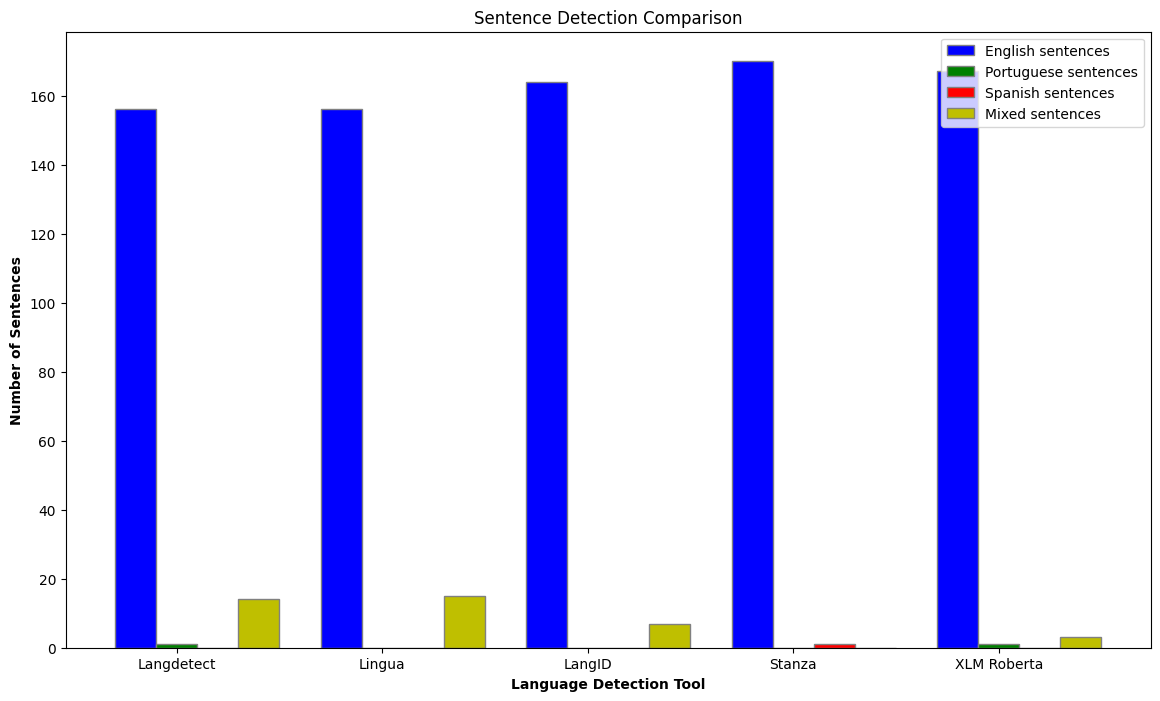

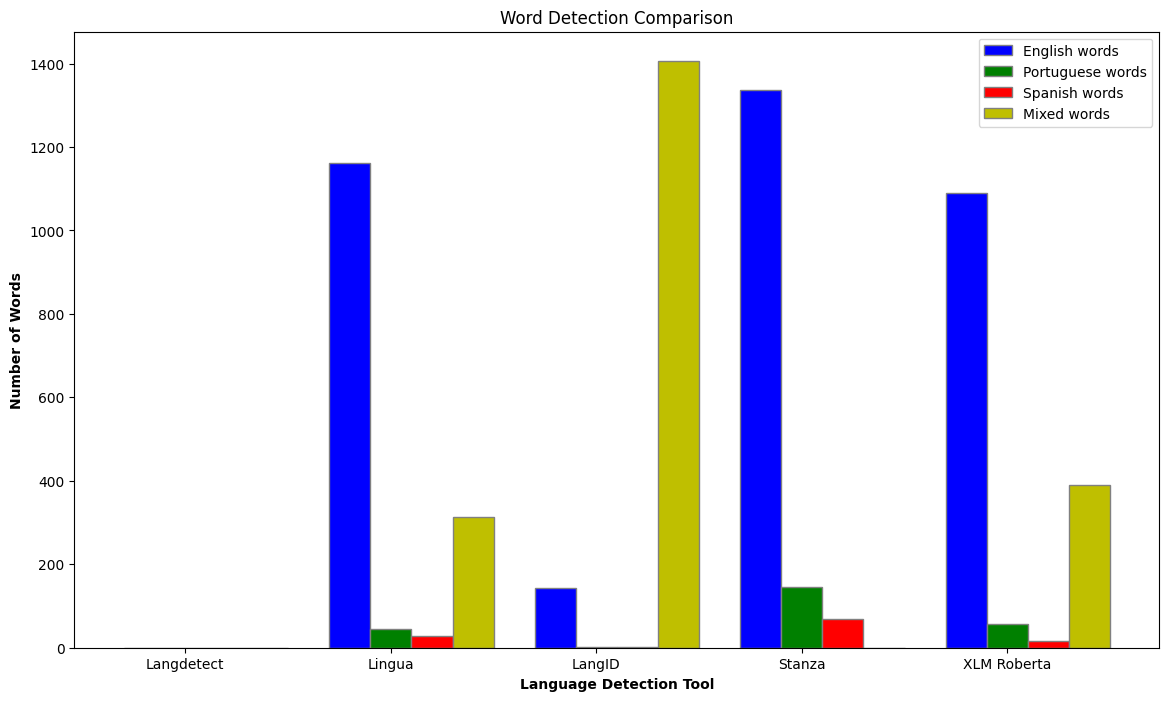

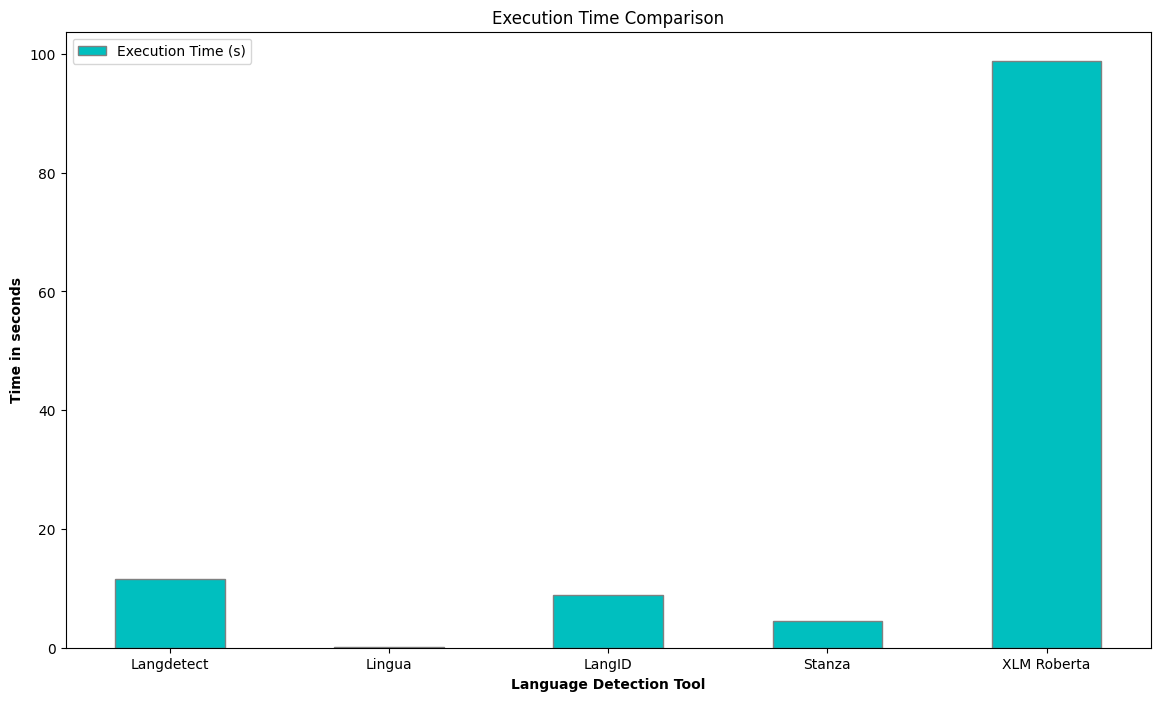

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the tools and data
tools = ['Langdetect', 'Lingua', 'LangID', 'Stanza', 'XLM Roberta']

# Data for sentence counts
english_sentences = [156, 156, 164, 170, 167]
portuguese_sentences = [1, 0, 0, 0, 1]
spanish_sentences = [0, 0, 0, 1, 0]
mixed_sentences = [14, 15, 7, 0, 3]

# Data for word counts
english_words = [0, 1162, 143, 1336, 1089]
portuguese_words = [0, 46, 1, 146, 57]
spanish_words = [0, 28, 1, 68, 15]
mixed_words = [0, 314, 1406, 0, 389]

# Time taken by each tool
times = [11.5, 0.2, 8.8, 4.5, 98.8]  # Time in seconds

# Number of groups
n_groups = len(tools)

# Create bar width
bar_width = 0.2

# Set position of bar on X axis
r1 = np.arange(n_groups)
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]

# Create the bars for sentence count
plt.figure(figsize=(14, 8))
plt.bar(r1, english_sentences, color='b', width=bar_width, edgecolor='grey', label='English sentences')
plt.bar(r2, portuguese_sentences, color='g', width=bar_width, edgecolor='grey', label='Portuguese sentences')
plt.bar(r3, spanish_sentences, color='r', width=bar_width, edgecolor='grey', label='Spanish sentences')
plt.bar(r4, mixed_sentences, color='y', width=bar_width, edgecolor='grey', label='Mixed sentences')
plt.xlabel('Language Detection Tool', fontweight='bold')
plt.ylabel('Number of Sentences', fontweight='bold')
plt.xticks([r + bar_width for r in range(n_groups)], tools)
plt.legend()
plt.title('Sentence Detection Comparison')
plt.show()

# Create the bars for word count
plt.figure(figsize=(14, 8))
plt.bar(r1, english_words, color='b', width=bar_width, edgecolor='grey', label='English words')
plt.bar(r2, portuguese_words, color='g', width=bar_width, edgecolor='grey', label='Portuguese words')
plt.bar(r3, spanish_words, color='r', width=bar_width, edgecolor='grey', label='Spanish words')
plt.bar(r4, mixed_words, color='y', width=bar_width, edgecolor='grey', label='Mixed words')
plt.xlabel('Language Detection Tool', fontweight='bold')
plt.ylabel('Number of Words', fontweight='bold')
plt.xticks([r + bar_width for r in range(n_groups)], tools)
plt.legend()
plt.title('Word Detection Comparison')
plt.show()

# Create the bars for execution time comparison
plt.figure(figsize=(14, 8))
plt.bar(tools, times, color='c', width=0.5, edgecolor='grey', label='Execution Time (s)')
plt.xlabel('Language Detection Tool', fontweight='bold')
plt.ylabel('Time in seconds', fontweight='bold')
plt.title('Execution Time Comparison')
plt.legend()
plt.show()